# <p style="text-align: center;"><strong>**“Red Wine Quality Prediction”**</strong></p>

**Data Analytics - Project**

Kacper Błachowiak, Jakub Ciura

## 1. Problem formulation

### 1.1 Project Goal

The project goal is to predict quality of variants of the Portuguese "Vinho Verde".
Prediction will be based on values of selected input variables such as: fixed acidity,
volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur
dioxide, density, pH, sulphates, alcohol.

### 1.2 Purpose of Creating a Model and Potential Use Cases

The main goal of building a model using this dataset is to predict the quality of red wine based on its physicochemical properties. By analyzing these features, a predictive model can help estimate the wine quality score without the need for costly and time-consuming expert tastings.

Potential use cases include:

  -  Assisting winemakers in quality control by identifying batches with likely high or low quality before distribution.

- Supporting decisions in blending and production processes to improve overall wine quality.

- Enabling retailers and consumers to better understand and evaluate wine quality through data-driven insights.

- Serving as a benchmark for developing more advanced machine learning models in food and beverage quality assessment.

### 1.3 Source of the data and contents

The data comes from a public dataset available on Kaggle, based on research published by Cortez et al. in 2009. This dataset was created to analyze the quality of red wine based on various physicochemical properties.

It contains 1,599 samples of red wine, each described by 11 physicochemical features such as fixed acidity, volatile acidity, residual sugar, pH, sulfur dioxide levels, and alcohol content. Each sample is also assigned a quality score ranging from 0 to 10, given by expert tasters. The goal of this dataset is to enable analysis and modeling of the relationship between the chemical characteristics and the wine quality rating.

Kaggle dataset: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

### 1.4 DAG

Based on the reviewed sources, a diagram was created to illustrate the influence of individual wine features on its quality [1-4].

/tmp/ipykernel_2648/2522413937.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


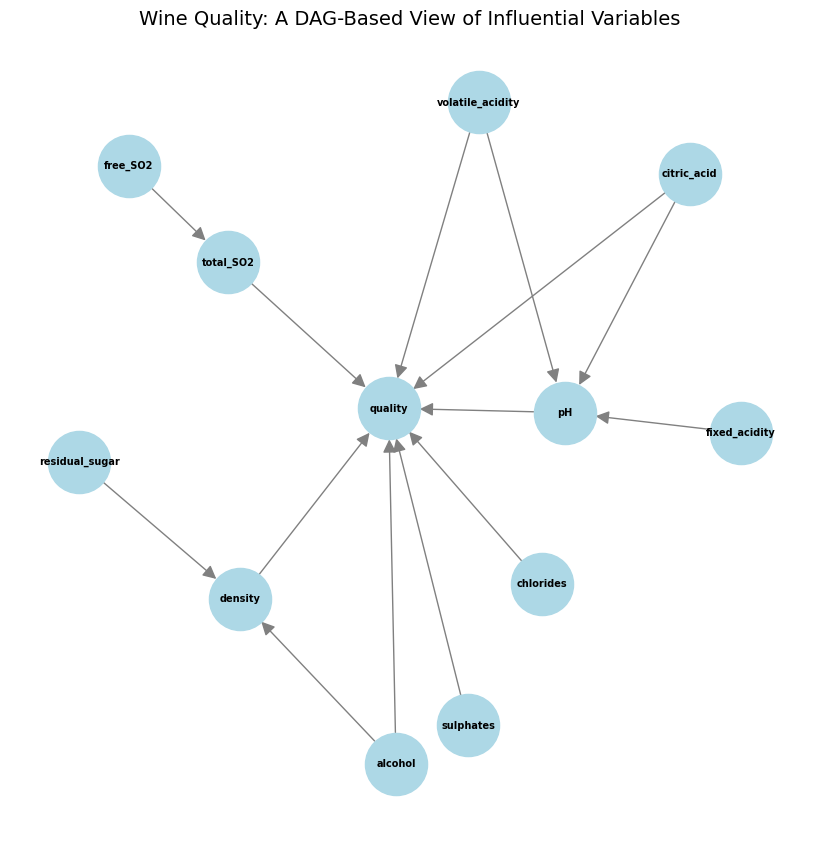

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Graph definition
G = nx.DiGraph()

# Edge definition
edges = [
    ('fixed_acidity', 'pH'),
    ('volatile_acidity', 'pH'),
    ('citric_acid', 'pH'),
    ('pH', 'quality'),
    ('free_SO2', 'total_SO2'),
    ('total_SO2', 'quality'),
    ('residual_sugar', 'density'),
    ('alcohol', 'density'),
    ('density', 'quality'),
    ('alcohol', 'quality'),
    ('sulphates', 'quality'),
    ('chlorides', 'quality'),
    ('volatile_acidity', 'quality'),
    ('citric_acid', 'quality'),
]

G.add_edges_from(edges)

# Layout setup
pos = nx.kamada_kawai_layout(G)

pos['citric_acid'][0] += 0.6  
pos['citric_acid'][1] -= 0.1  
pos['residual_sugar'][1] += 0.4 
pos['free_SO2'][0] += 0.2

# Graph drawing
plt.figure(figsize=(8, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_color='lightblue',
    node_size=2000,
    font_size=7,
    font_weight='bold',
    edge_color='gray',
    arrowsize=20
)
plt.title("Wine Quality: A DAG-Based View of Influential Variables", fontsize=14) 
plt.tight_layout()
plt.show()


The graph structure reflects key relationships among the physicochemical features influencing red Vinho Verde wine quality. 

Acidity components such as **fixed acidity**, **volatile acidity**, and **citric acid** collectively determine the **pH level**, which acts as an important mediator affecting the overall **quality** of the wine.

**Density** is modeled as dependent on both **alcohol content** and **residual sugar**, capturing their combined effect on the physical properties of the wine. 

**Total sulfur dioxide** is represented as influenced by **free sulfur dioxide**, highlighting the chemical balance relevant to wine stability and sensory characteristics.

Direct effects on wine **quality** are included for **alcohol** and **sulphates** due to their well-known impact on sensory perception and overall wine profile. 

Additionally, **chlorides** are accounted for as they can influence taste and, consequently, **quality**.


### 1.5 Confounding structures in the dataset

#### Fork

| Relationship                      | Description                                              |
| --------------------------------- | -------------------------------------------------------- |
| `pH ← volatile_acidity → quality` | Volatile acidity affects pH and directly impacts quality |
| `pH ← citric_acid → quality`      | Citric acid affects pH and directly impacts quality      |
| `density ← alcohol → quality`     | Alcohol affects both density and quality                 |



####  Pipe

| Relationship                         | Description                                              |
| ------------------------------------ | -------------------------------------------------------- |
| `fixed_acidity → pH → quality`       | pH mediates the effect of fixed acidity on quality       |
| `volatile_acidity → pH → quality`    | pH mediates the effect of volatile acidity on quality    |
| `citric_acid → pH → quality`         | Citric acid affects quality indirectly through pH        |
| `free_SO2 → total_SO2 → quality`     | Total SO2 mediates the effect of free SO2 on quality     |
| `alcohol → density → quality`        | Density mediates the effect of alcohol on quality        |
| `residual_sugar → density → quality` | Density mediates the effect of residual sugar on quality |



#### Collider

| Relationship                               | Description                                               |
| ------------------------------------------ | --------------------------------------------------------- |
| `citric_acid → quality ← fixed_acidity`    | Quality is a common outcome influenced by both predictors |
| `citric_acid → quality ← volatile_acidity` | Quality is influenced by both citric and volatile acidity |
| `residual_sugar → quality ← pH`            | Quality is influenced by residual sugar and pH            |
| `chlorides → quality ← pH`                 | Quality is influenced by chlorides and pH                 |
| `total_SO2 → quality ← sulphates`          | Quality is influenced by total SO2 and sulphates          |
| `alcohol → quality ← sulphates`            | Quality is influenced by both alcohol and sulphates       |
| `density → quality ← alcohol`              | Quality is influenced by both density and alcohol         |
| `density → quality ← pH`                   | Quality is influenced by both density and pH              |


Five predictors were selected as the most suitable for use in the models presented further in this work.

**Model 1:** alcohol, volatile acidity and sulphates.

**Model 2:** alcohol, volatile acidity, sulphates, citric acid and density.

## 2. Data preprocessing

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Descriptive statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000    

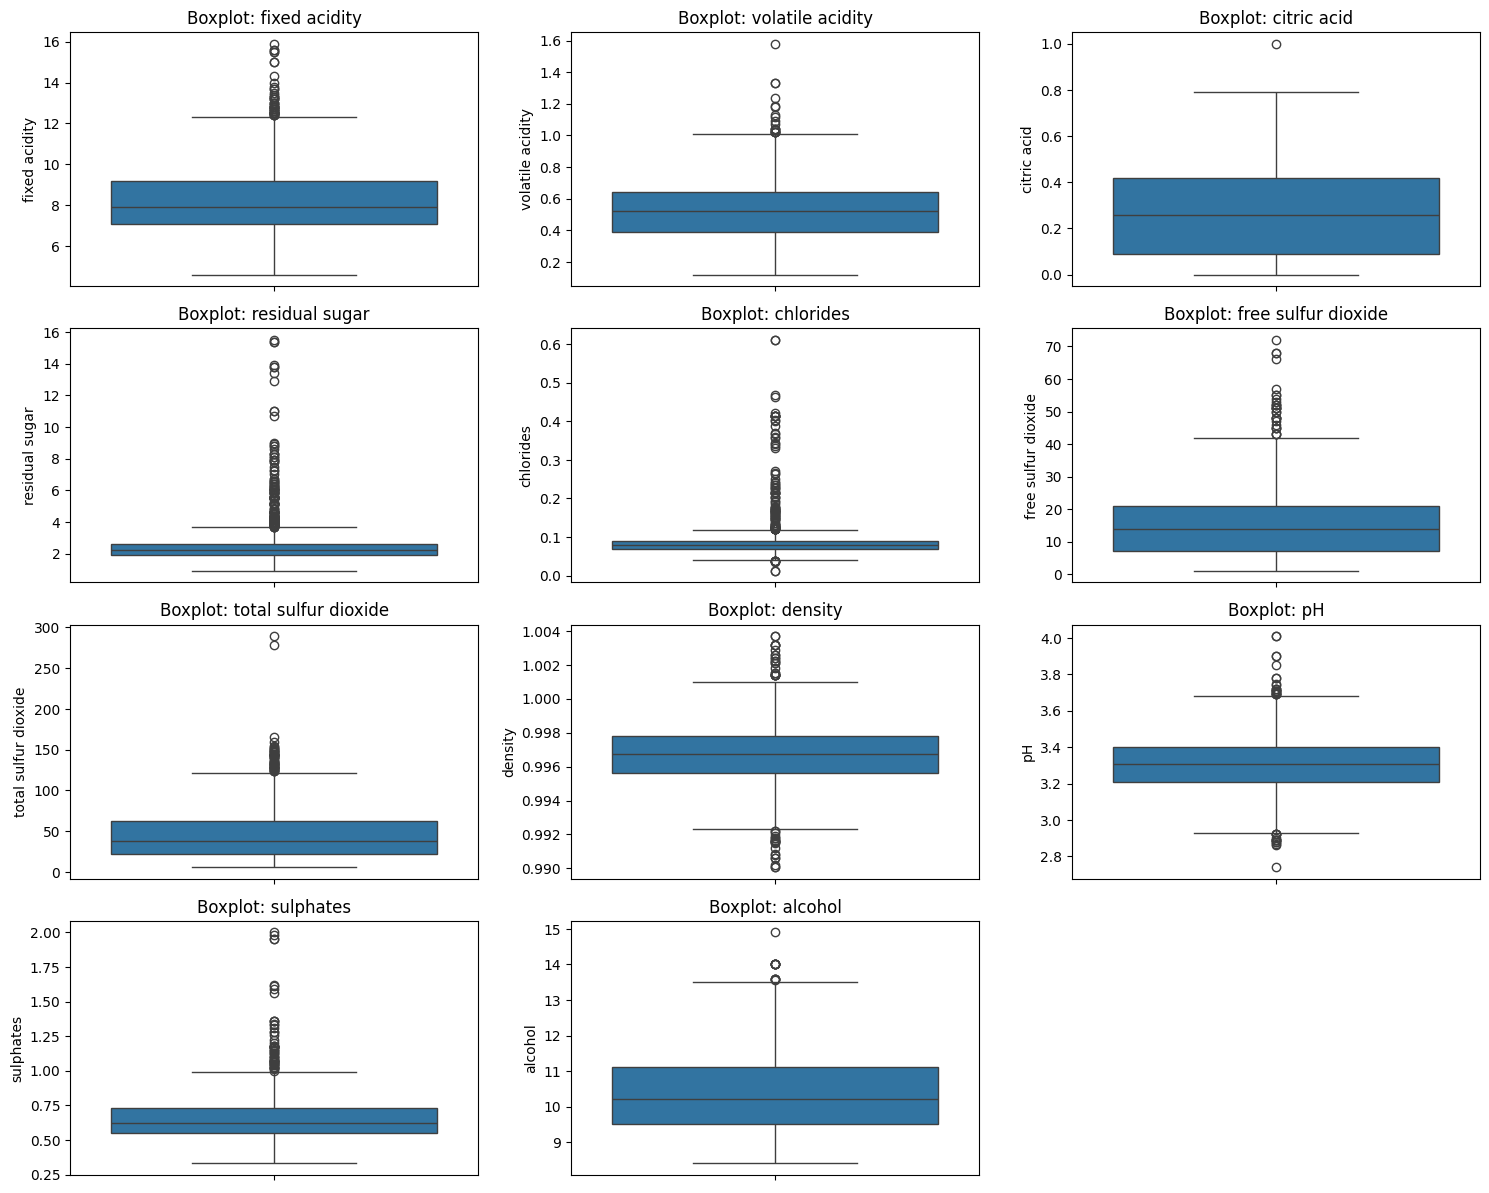

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load dataset
df = pd.read_csv("projekt/data/winequality-red.csv")

# 1. Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# 2. Display descriptive statistics
print("\nDescriptive statistics:")
print(df.describe())

# 3. Detect outliers using z-score method
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)
print("\nNumber of outliers per column (|z| > 3):")
print(outliers)

# Plot boxplots in a 4x3 grid
feature_columns = df.columns.drop("quality")  # Select input feature columns (excluding target 'quality')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # Flatten axes array for easy iteration

for i, col in enumerate(feature_columns):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot: {col}")

# Remove empty subplots
for j in range(len(feature_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop("quality", axis=1))

X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns[:-1])
y = df["quality"]

The data downloaded from Kaggle is already prepared for the further steps of the project – it does not contain any missing values. Outlier analysis indicated that several features (e.g., total sulfur dioxide, residual sugar) contain extreme values based on z-score > 3. However, these values were retained, as they fall within chemically plausible ranges and reflect naturally occurring variation in wine production practices. The only preprocessing applied to the data was **standardization**. It was performed in order to improve the interpretability of model parameters and to facilitate the convergence of the Bayesian wine quality classifier.

## **3. Models**

### 3.1 Model 1

Creating data, which consists of predictors: *alcohol, volatile acidity, sulphates*.

For future analysis, data is being split to *test* and *train* subsets (ratio: 80/20).

In [3]:
# Selected predictors for model 1
selected_predictors = ["alcohol", "volatile acidity", "sulphates"]

# Standardize selected predictors
X_selected = df[selected_predictors].values
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

# Define target variable
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_selected, y, test_size=0.2, random_state=42)

# Prepare dictionary with training data for modeling
stan_data = {
    "N": X_train.shape[0],
    "K": X_train.shape[1],
    "X": X_train,
    "y": y_train
}

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 1279
Test samples: 320


In [4]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file="projekt/models/model1_1.stan")

fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

14:49:57 - cmdstanpy - INFO - compiling stan file /workspace/workspace/projekt/models/model1_1.stan to exe file /workspace/workspace/projekt/models/model1_1
14:50:20 - cmdstanpy - INFO - compiled model executable: /workspace/workspace/projekt/models/model1_1
14:50:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:50:21 - cmdstanpy - INFO - CmdStan done processing.



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -135.902000  0.033751  1.553870  1.393640 -138.837000 -135.590000   
alpha      5.625870  0.000277  0.019083  0.019348    5.594740    5.625770   
beta[1]    0.330912  0.000284  0.019269  0.019012    0.299133    0.331174   
beta[2]   -0.207401  0.000284  0.019464  0.019641   -0.239635   -0.207851   
beta[3]    0.105873  0.000268  0.018660  0.018559    0.075377    0.105691   
sigma      0.665749  0.000192  0.012852  0.012687    0.644979    0.665455   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__    -134.015000   2079.51   3201.85  1.000820  
alpha      5.657550   4766.69   2801.25  0.999716  
beta[1]    0.361836   4644.48   3120.15  1.000320  
beta[2]   -0.175231   4776.62   3058.50  1.000810  
beta[3]    0.136668   4898.35   3477.77  1.000410  
sigma      0.687448   4566.29   2937.46  1.002790  


#### Prior predictive check - model 1_1

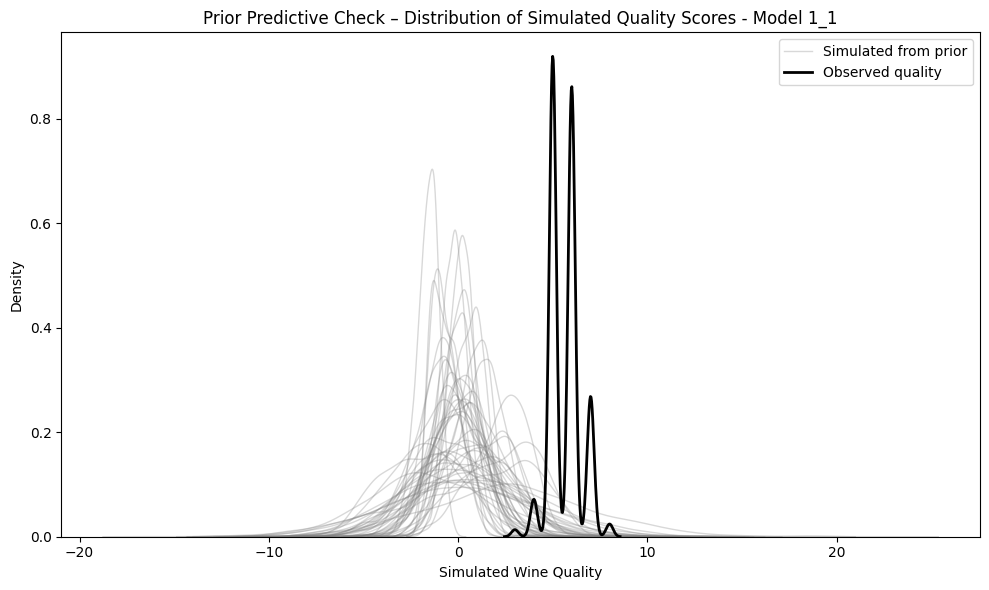

In [5]:
# Settings: number of samples and observations
n_samples = 500
n_obs = X_scaled_selected.shape[0]

# Generate prior samples for alpha, beta, and sigma
alpha_prior = np.random.normal(loc=0, scale=1, size=n_samples)
beta_prior = np.random.normal(loc=0, scale=1, size=(n_samples, 3))  # 3 predictors
sigma_prior = np.random.exponential(scale=1.0, size=n_samples)

# Perform prior predictive simulations
y_prior_samples = []
for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Convert list of simulations to numpy array
y_prior_samples = np.array(y_prior_samples)

# Plot several prior predictive density curves
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    label = "Simulated from prior" if i == 0 else None
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1, label=label)

# Overlay observed wine quality distribution for comparison
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")
plt.title("Prior Predictive Check – Distribution of Simulated Quality Scores - Model 1_1")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

The plot compares the distribution of wine quality scores generated from prior simulations (gray curves) with the distribution of actual observed data (black curve). The gray lines represent 50 random samples from the model's prior predictive distribution. Each line corresponds to a single simulated dataset generated using random draws from the prior distributions of the model parameters (`alpha`, `beta`, `sigma`). These curves illustrate the range of possible outcomes the model predicts **before seeing any data**.

We can see, that simulated quality scores doesn't make sense - should be between 3 to 8. Basing on this conclusion, the new version of model was prepared: *model1_2.stan*

### 3.2 Model 1_2

The key improvement was in making the priors more informative and grounded in domain knowledge, which significantly improved the model’s ability to generate plausible predictions and reflect the structure of the data.

In [6]:
model = CmdStanModel(stan_file="projekt/models/model1_2.stan")

fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

14:50:22 - cmdstanpy - INFO - compiling stan file /workspace/workspace/projekt/models/model1_2.stan to exe file /workspace/workspace/projekt/models/model1_2
14:50:40 - cmdstanpy - INFO - compiled model executable: /workspace/workspace/projekt/models/model1_2
14:50:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:50:41 - cmdstanpy - INFO - CmdStan done processing.



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -119.184000  0.035653  1.606680  1.364730 -122.276000 -118.825000   
alpha      5.627930  0.000261  0.018487  0.018510    5.597730    5.627850   
beta[1]    0.330779  0.000282  0.019401  0.019166    0.299440    0.330741   
beta[2]   -0.207406  0.000278  0.019058  0.019380   -0.238446   -0.207444   
beta[3]    0.105006  0.000272  0.018890  0.018799    0.074476    0.105109   
sigma      0.666413  0.000189  0.013245  0.012993    0.645128    0.666398   

                95%  ESS_bulk  ESS_tail    R_hat  
lp__    -117.281000   2029.35   2751.49  1.00020  
alpha      5.657790   5062.37   2388.35  1.00042  
beta[1]    0.363868   4873.97   2920.78  1.00427  
beta[2]   -0.176396   4701.51   3042.11  1.00100  
beta[3]    0.135996   4863.06   3216.82  1.00289  
sigma      0.687968   4973.03   2706.31  1.00176  


#### Prior predictive check - model 1_2

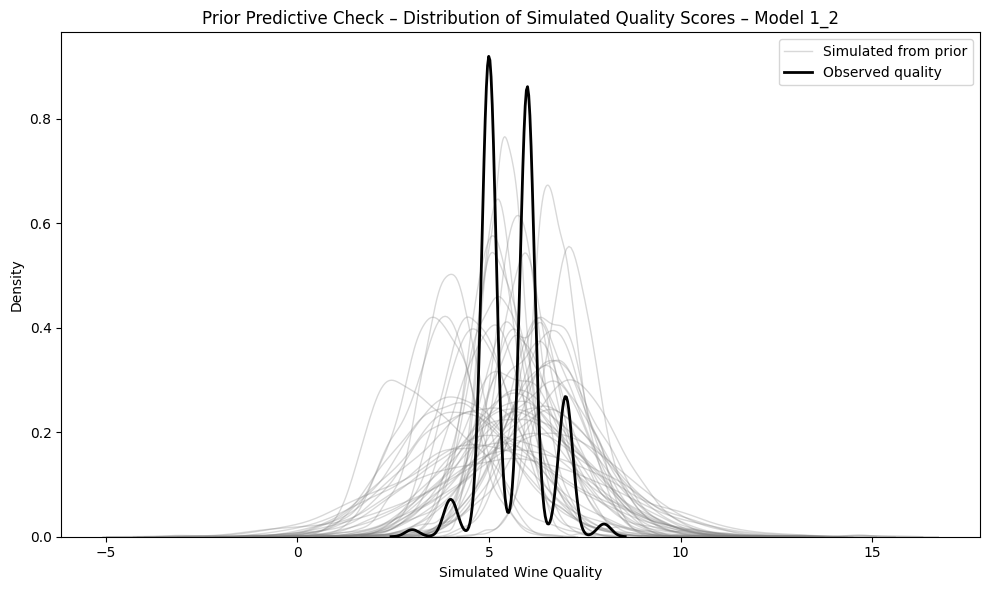

In [7]:
# Settings: number of samples and observations
n_samples = 500
n_obs = X_scaled_selected.shape[0]

# Generate prior samples for alpha, beta, and sigma
alpha_prior = np.random.normal(loc=5.5, scale=1.0, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=0.5, size=(n_samples, 3))
sigma_prior = np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_samples))  # T[0,]

# Perform prior predictive simulations
y_prior_samples = []
for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Convert list of simulations to numpy array
y_prior_samples = np.array(y_prior_samples)

# Plot several prior predictive density curves
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    label = "Simulated from prior" if i == 0 else None
    sns.kdeplot(y_prior_samples[i], color="gray", alpha=0.3, linewidth=1, label=label)

# Overlay observed wine quality distribution for comparison
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")
plt.title("Prior Predictive Check – Distribution of Simulated Quality Scores – Model 1_2")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

The prior mean for the intercept (alpha) was set around 5.5 to reflect the average wine quality score observed in the dataset, while the standard deviation of 1.0 allows reasonable variability. 

After adjusting our priors to be more informative (centered around expected quality levels and with reduced variance), the prior predictive check showed that the simulated data aligns well with the observed range of wine quality (mostly between 3 and 8). This confirms that our prior beliefs do not produce implausible outputs and are suitable for further posterior inference.

#### Posterior distribution check - model 1_2

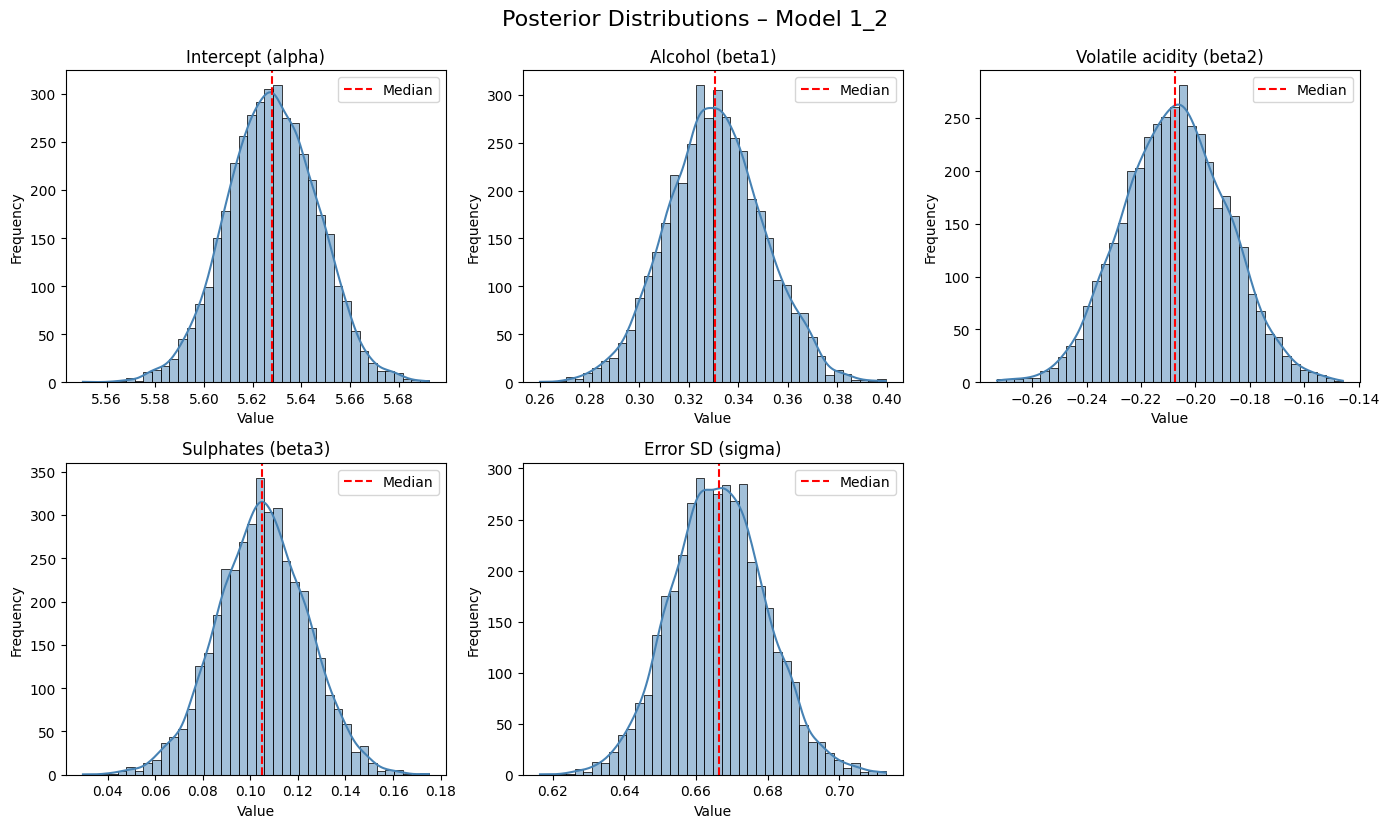

In [8]:
# Extract posterior samples as a DataFrame
posterior_df = fit.draws_pd()

# Define parameters and their labels for plotting
param_names = ['alpha', 'beta[1]', 'beta[2]', 'beta[3]', 'sigma']
param_labels = {
    'alpha': 'Intercept (alpha)',
    'beta[1]': 'Alcohol (beta1)',
    'beta[2]': 'Volatile acidity (beta2)',
    'beta[3]': 'Sulphates (beta3)',
    'sigma': 'Error SD (sigma)'
}


# Plot histogram and KDE with median line for each parameter
plt.figure(figsize=(14, 8))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 3, i)
    sns.histplot(posterior_df[param], bins=40, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels[param])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 1_2", fontsize=16, y=1.03)
plt.show()

The posterior distributions for Model 1.2 indicate that alcohol content has the strongest positive association with wine quality, while volatile acidity appears to slightly reduce it. Sulphates have a weak positive effect, but the posterior is still close to zero, suggesting limited evidence for strong influence. The posterior for sigma shows a low residual variance, indicating that the model fits the data fairly well.

#### Posterior predictive check - model 1_2

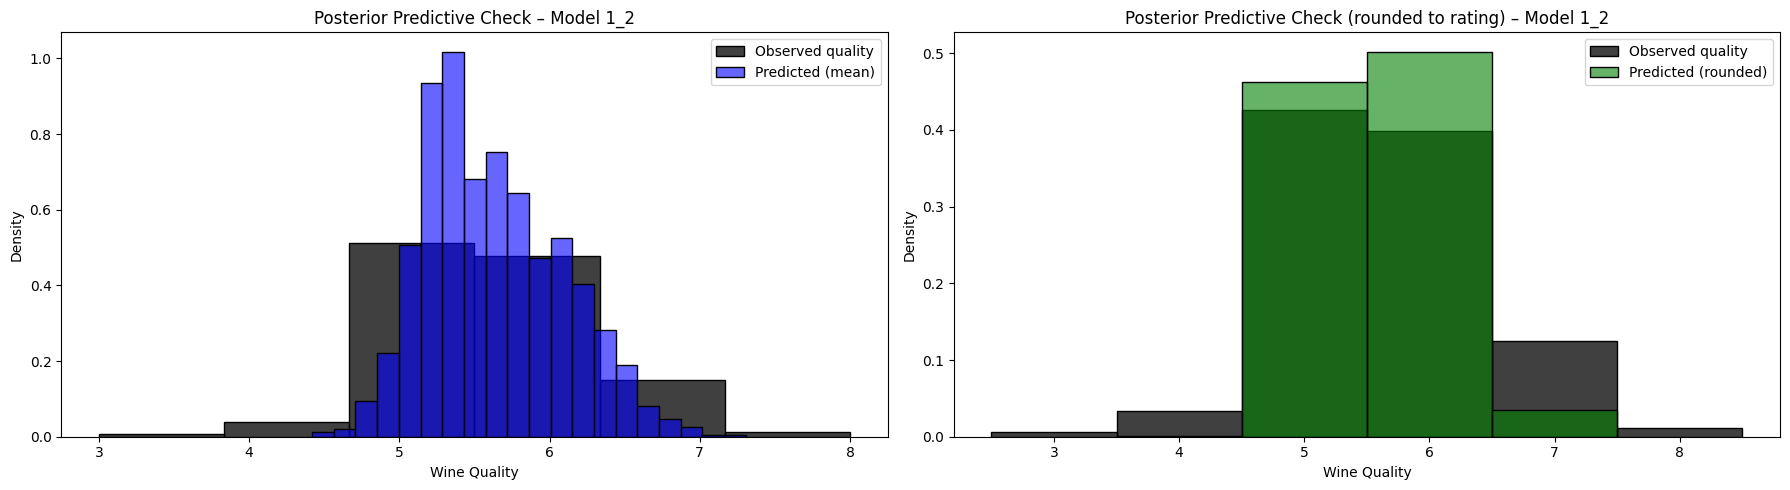

In [9]:
# Extract posterior samples
posterior_df = fit.draws_pd()
alpha_samples = posterior_df["alpha"].values
beta_samples = posterior_df[["beta[1]", "beta[2]", "beta[3]"]].values
sigma_samples = posterior_df["sigma"].values

# Generate predictions using a subset of posterior samples
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_selected @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Convert predictions to numpy array
y_pred_samples = np.array(y_pred_samples)


# Plot observed vs predicted wine quality densities
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(y, bins=6, color="black", label="Observed quality", stat="density", ax=axes[0])
sns.histplot(y_pred_samples.mean(axis=0), bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density", ax=axes[0])
axes[0].set_title("Posterior Predictive Check – Model 1_2")
axes[0].set_xlabel("Wine Quality")
axes[0].set_ylabel("Density")
axes[0].legend()

sns.histplot(y, bins=range(int(y.min()), int(y.max()) + 2), color="black", label="Observed quality", stat="density", discrete=True, ax=axes[1])
sns.histplot(np.round(y_pred_samples.mean(axis=0)), bins=range(int(y.min()), int(y.max()) + 2), color="green", alpha=0.6, label="Predicted (rounded)", stat="density", discrete=True, ax=axes[1])
axes[1].set_title("Posterior Predictive Check (rounded to rating) – Model 1_2")
axes[1].set_xlabel("Wine Quality")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()


For better presentation and interpretation of the results, the predicted wine quality scores were rounded to the nearest integer. Since the observed target variable in the dataset represents discrete quality ratings, rounding the model's continuous predictions allows for a more direct and realistic comparison with the actual data. This facilitates a clearer evaluation of model performance, especially in terms of how well the predictions align with the observed categorical outcomes.

### 3.3 Model 1_3

To improve the model’s flexibility, a new version was created: model1_3.stan. The main difference compared to the previous version was the use of more flexible priors — the standard deviations of alpha and beta were increased. Additionally, sigma's function was changed to exponential.

In [10]:
model = CmdStanModel(stan_file="projekt/models/model1_3.stan")

fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit.summary())

14:50:44 - cmdstanpy - INFO - compiling stan file /workspace/workspace/projekt/models/model1_3.stan to exe file /workspace/workspace/projekt/models/model1_3
14:50:59 - cmdstanpy - INFO - compiled model executable: /workspace/workspace/projekt/models/model1_3
14:51:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:51:01 - cmdstanpy - INFO - CmdStan done processing.



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -119.760000  0.032689  1.536190  1.389200 -122.707000 -119.460000   
alpha      5.627580  0.000293  0.018941  0.019341    5.596980    5.627530   
beta[1]    0.331358  0.000292  0.019322  0.019301    0.300160    0.331263   
beta[2]   -0.207361  0.000317  0.019395  0.019240   -0.239898   -0.207305   
beta[3]    0.105348  0.000290  0.018672  0.018794    0.074964    0.105363   
sigma      0.665992  0.000189  0.013328  0.013517    0.644108    0.666014   

                95%  ESS_bulk  ESS_tail     R_hat  
lp__    -117.845000   2225.02   2983.23  1.001400  
alpha      5.658670   4417.15   3007.92  0.999845  
beta[1]    0.363715   4448.55   3255.65  1.001020  
beta[2]   -0.175376   3818.18   3423.25  1.001270  
beta[3]    0.136074   4235.75   3276.72  1.000500  
sigma      0.688018   4935.58   3084.95  1.001940  


#### Prior predictive check - model 1_3

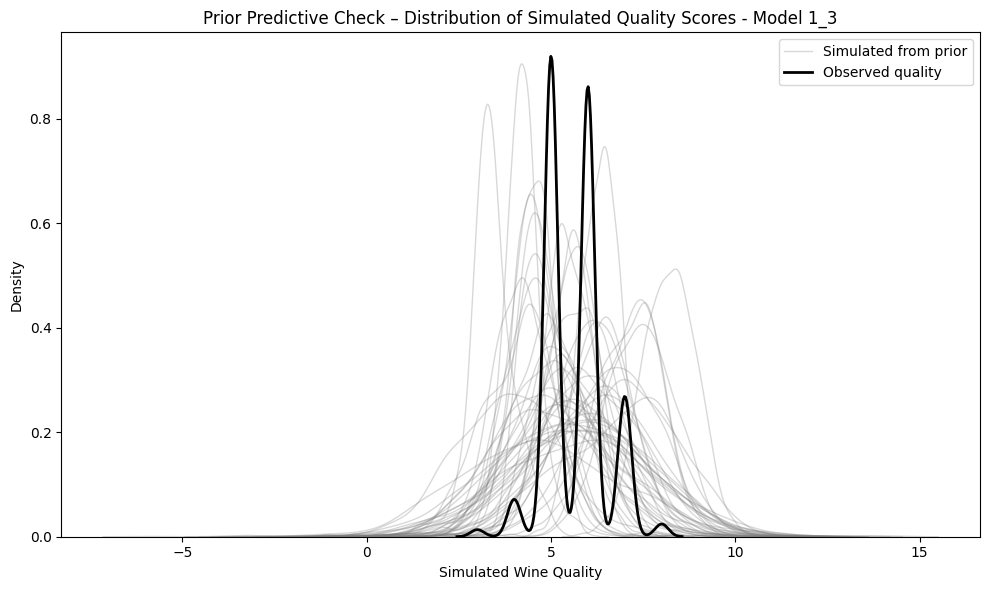

In [11]:
# Settings: number of samples and observations
n_samples = 500 
n_obs = X_scaled_selected.shape[0]

# Generate prior samples for alpha, beta, and sigma
alpha_prior = np.random.normal(loc=5.5, scale=1.0, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=0.5, size=(n_samples, 3))
sigma_prior = np.abs(np.random.normal(loc=0.0, scale=1.0, size=n_samples))  # T[0,]

# Perform prior predictive simulations
y_prior_samples = []
for i in range(n_samples):
    mu = X_scaled_selected @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Convert list of simulations to numpy array
y_prior_samples1_3 = np.array(y_prior_samples)

# Plot several prior predictive density curves
plt.figure(figsize=(10, 6))
for i in range(50):  # 50 z 500
    label = "Simulated from prior" if i == 0 else None
    sns.kdeplot(y_prior_samples1_3[i], color="gray", alpha=0.3, linewidth=1, label=label)

# Overlay observed wine quality distribution for comparison
sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")

plt.title("Prior Predictive Check – Distribution of Simulated Quality Scores - Model 1_3")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

#### Posterior distribution check - model 1_3

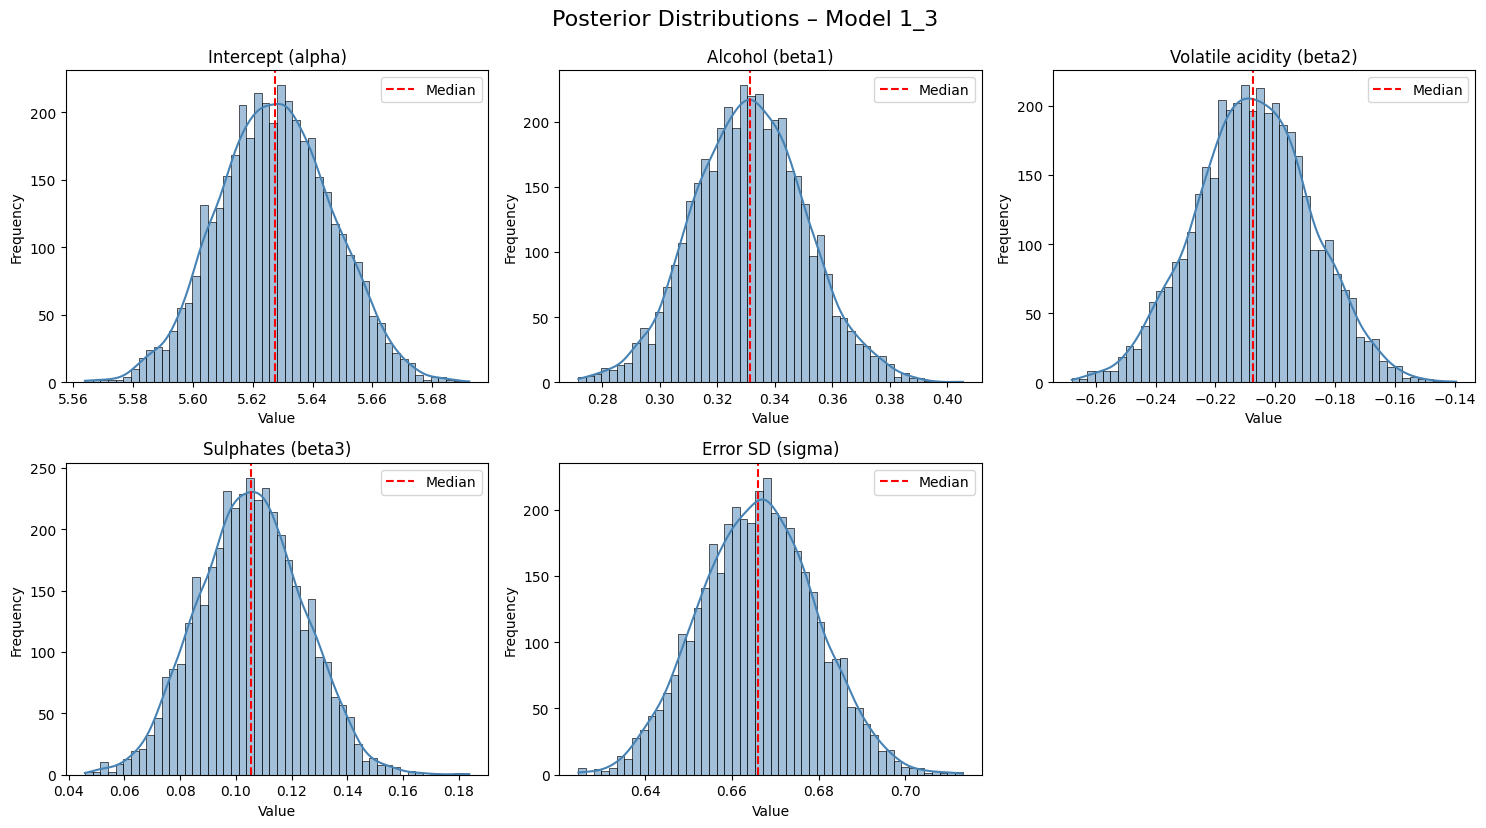

In [12]:
# Extract posterior samples as a DataFrame
posterior_df = fit.draws_pd()

# Define parameters and their labels for plotting
param_names = [col for col in posterior_df.columns if col.startswith("alpha") or col.startswith("beta") or col == "sigma"]


# Define parameters and their labels for plotting
param_labels = {
    "alpha": "Intercept (alpha)",
    "beta[1]": "Alcohol (beta1)",
    "beta[2]": "Volatile acidity (beta2)",
    "beta[3]": "Sulphates (beta3)",
    "sigma": "Error SD (sigma)"
}

# Plot histogram and KDE with median line for each parameter
plt.figure(figsize=(15, 8))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 3, i)
    sns.histplot(posterior_df[param], bins=50, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels.get(param, param))  # fallback jeśli czegoś brakuje
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 1_3", fontsize=16, y=1.03)
plt.show()


#### Posterior predictive check - model 1_3

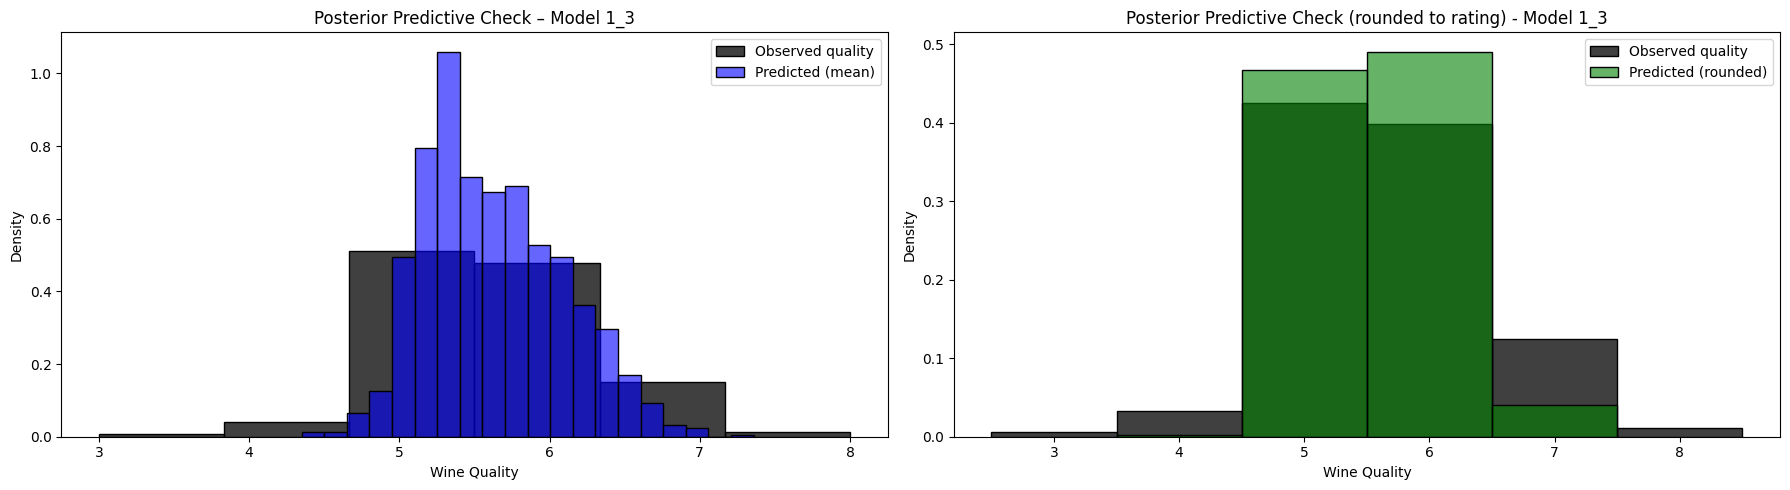

In [13]:
#Extract posterior samples
posterior_df = fit.draws_pd()
alpha_samples = posterior_df["alpha"].values
beta_samples = posterior_df[["beta[1]", "beta[2]", "beta[3]"]].values
sigma_samples = posterior_df["sigma"].values

# Generate predictions using a subset of posterior samples
n_draws = 500
y_pred_samples = []
for i in range(n_draws):
    mu = X_scaled_selected @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Convert predictions to numpy array
y_pred_samples = np.array(y_pred_samples)
y_pred_mean1_3 = y_pred_samples.mean(axis=0)

# Plot observed vs predicted wine quality densities
fig1, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(y, bins=6, color="black", label="Observed quality", stat="density", ax=axes[0])
sns.histplot(y_pred_mean1_3, bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density", ax=axes[0])
axes[0].set_title("Posterior Predictive Check – Model 1_3")
axes[0].set_xlabel("Wine Quality")
axes[0].set_ylabel("Density")
axes[0].legend()

sns.histplot(y, bins=range(int(y.min()), int(y.max()) + 2), color="black", label="Observed quality", stat="density", discrete=True, ax=axes[1])
sns.histplot(np.round(y_pred_mean1_3), bins=range(int(y.min()), int(y.max()) + 2), color="green", alpha=0.6, label="Predicted (rounded)", stat="density", discrete=True, ax=axes[1])
axes[1].set_title("Posterior Predictive Check (rounded to rating) - Model 1_3")
axes[1].set_xlabel("Wine Quality")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()


The revised Model 1.3 with more flexible priors better reflects the observed variability in wine quality. The posterior predictive distribution is now wider and more aligned with the empirical distribution. However, the model still underestimates the tails, indicating that additional explanatory variables may be required — this will be addressed in Model 2.

Prediction tests were conducted on randomly selected samples from test set.

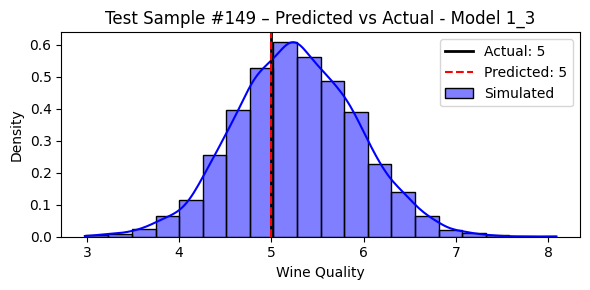

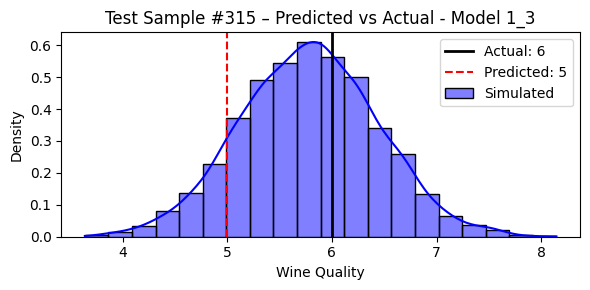

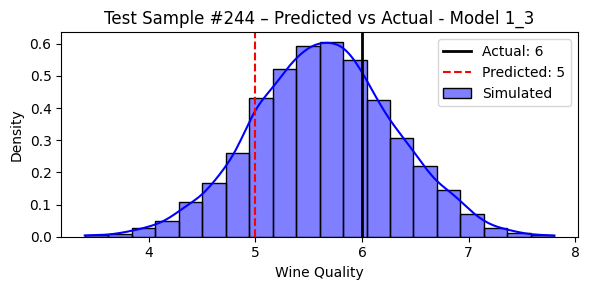

In [30]:
import random

# Posterior predictive check on random test samples
for i in range(3):
    # Select a random test sample
    idx = random.randint(0, len(X_test) - 1)

    # Calculate predicted distribution for selected sample
    mu_i = X_test[idx] @ beta_samples.T + alpha_samples
    y_sim_i = np.random.normal(mu_i, sigma_samples)

    # Determine predicted quality as the mode of simulated values
    quality_range = np.arange(0, 11)
    bin_edges = np.arange(0, 12)
    counts, _ = np.histogram(y_sim_i, bins=bin_edges)
    predicted_quality = quality_range[np.argmax(counts)]

    # Retrieve actual quality for comparison
    y_actual = int(y_test.iloc[idx])

    # Plot simulated distribution with actual and predicted quality lines
    plt.figure(figsize=(6, 3))
    sns.histplot(y_sim_i, bins=20, kde=True, color='blue', stat="density", label='Simulated')
    plt.axvline(y_actual, color='black', linestyle='-',linewidth=2, label=f'Actual: {y_actual}')
    plt.axvline(predicted_quality, color='red', linestyle='--', label=f'Predicted: {predicted_quality}')

    plt.title(f'Test Sample #{idx} – Predicted vs Actual - Model 1_3')
    plt.xlabel("Wine Quality")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

Prediction accuracy was evaluated on the entire test set.

In [15]:
# Test set accuracy

# Generate posterior predictive samples for the entire test set
y_pred_samples_test = []
for i in range(len(alpha_samples)):
    mu_test = X_test @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu_test, sigma_samples[i])
    y_pred_samples_test.append(y_sim)

# Convert list of predictions to numpy array and compute mean predictions
y_pred_samples_test = np.array(y_pred_samples_test)
y_pred_mean_test = y_pred_samples_test.mean(axis=0)

# Calculate accuracy by comparing rounded predictions to actual test labels
accuracy_model1_test = np.mean(np.round(y_pred_mean_test) == np.round(y_test))
print(f"Accuracy (Model 1_3, on test set): {accuracy_model1_test:.3f}")

Accuracy (Model 1_3, on test set): 0.556


### 3.4 Model 2

Implementing version close to Model1_3, but with 5 predictors - added citric acid and density.

In [16]:
# Define new set of predictors for Model 2
predictors_model2 = ["alcohol", "volatile acidity", "sulphates", "citric acid", "density"]

# Standardize new predictors
X_model2 = df[predictors_model2].values
scaler2 = StandardScaler()
X_scaled_model2 = scaler2.fit_transform(X_model2)

# Split standardized data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_model2, y, test_size=0.2, random_state=42)

# Prepare dictionary with training data for modeling
stan_data2 = {
    "N": X_train.shape[0],
    "K": X_train.shape[1],
    "X": X_train,
    "y": y_train
}

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 1279
Test samples: 320


In [17]:
model2 = CmdStanModel(stan_file="projekt/models/model2_1.stan")

fit2 = model2.sample(
    data=stan_data2,
    chains=4,
    parallel_chains=4,
    seed=42
)

print(fit2.summary())

14:51:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:51:06 - cmdstanpy - INFO - CmdStan done processing.
14:51:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1.stan', line 19, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1.stan', line 19, column 2 to column 38)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1.stan', line 19, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!



               Mean      MCSE    StdDev       MAD          5%         50%  \
lp__    -119.738000  0.044745  1.878070  1.732420 -123.268000 -119.368000   
alpha      5.627570  0.000235  0.019091  0.018784    5.596850    5.627740   
beta[1]    0.347535  0.000364  0.022833  0.022678    0.309944    0.347584   
beta[2]   -0.221263  0.000353  0.023328  0.023613   -0.259627   -0.221392   
beta[3]    0.105399  0.000246  0.019517  0.019254    0.073456    0.105598   
beta[4]   -0.029927  0.000437  0.025880  0.025851   -0.072534   -0.029646   
beta[5]    0.034899  0.000434  0.025072  0.025499   -0.006869    0.035354   
sigma      0.665888  0.000171  0.013090  0.013665    0.644500    0.665710   

                95%  ESS_bulk  ESS_tail    R_hat  
lp__    -117.354000   1777.37   2658.02  1.00058  
alpha      5.658910   6763.48   3108.04  1.00156  
beta[1]    0.385939   3974.15   2930.71  1.00088  
beta[2]   -0.183026   4413.14   3362.83  1.00022  
beta[3]    0.136462   6445.49   2956.51  1.00230  

#### Prior predictive check - model 2_1

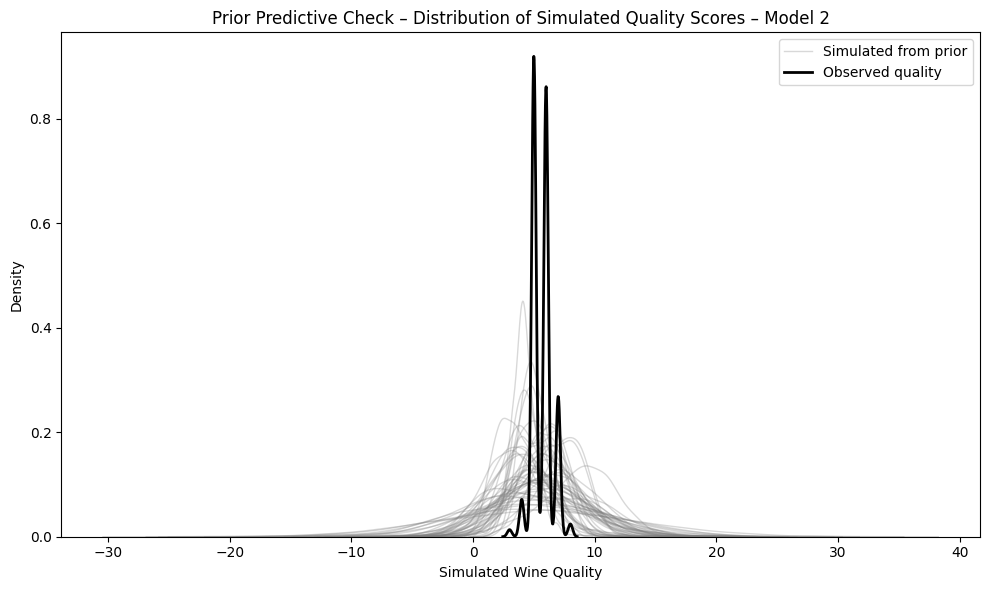

In [18]:
# Prior predictive check setup for Model 2 with 5 predictors
n_samples = 500
n_obs = X_scaled_model2.shape[0]

# Generate prior samples for alpha, beta, and sigma with adjusted parameters
alpha_prior = np.random.normal(loc=5.5, scale=1.5, size=n_samples)
beta_prior = np.random.normal(loc=0.0, scale=1.0, size=(n_samples, 5))  # 5 predictors
sigma_prior = np.random.exponential(scale=2.0, size=n_samples) 

# Perform prior predictive simulations
y_prior_samples = []
for i in range(n_samples):
    mu = X_scaled_model2 @ beta_prior[i] + alpha_prior[i]
    y_sim = np.random.normal(mu, sigma_prior[i])
    y_prior_samples.append(y_sim)

# Convert simulations list to numpy array
y_prior_samples2_1 = np.array(y_prior_samples)

# Plot multiple prior predictive density curves and observed data for comparison
plt.figure(figsize=(10, 6))
for i in range(50):  # tylko kilkanaście-50 krzywych
    label = "Simulated from prior" if i == 0 else None
    sns.kdeplot(y_prior_samples2_1[i], color="gray", alpha=0.3, linewidth=1, label=label)

sns.kdeplot(y, color="black", linewidth=2, label="Observed quality")
plt.title("Prior Predictive Check – Distribution of Simulated Quality Scores – Model 2")
plt.xlabel("Simulated Wine Quality")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

#### Posterior distribution check - model 2_1

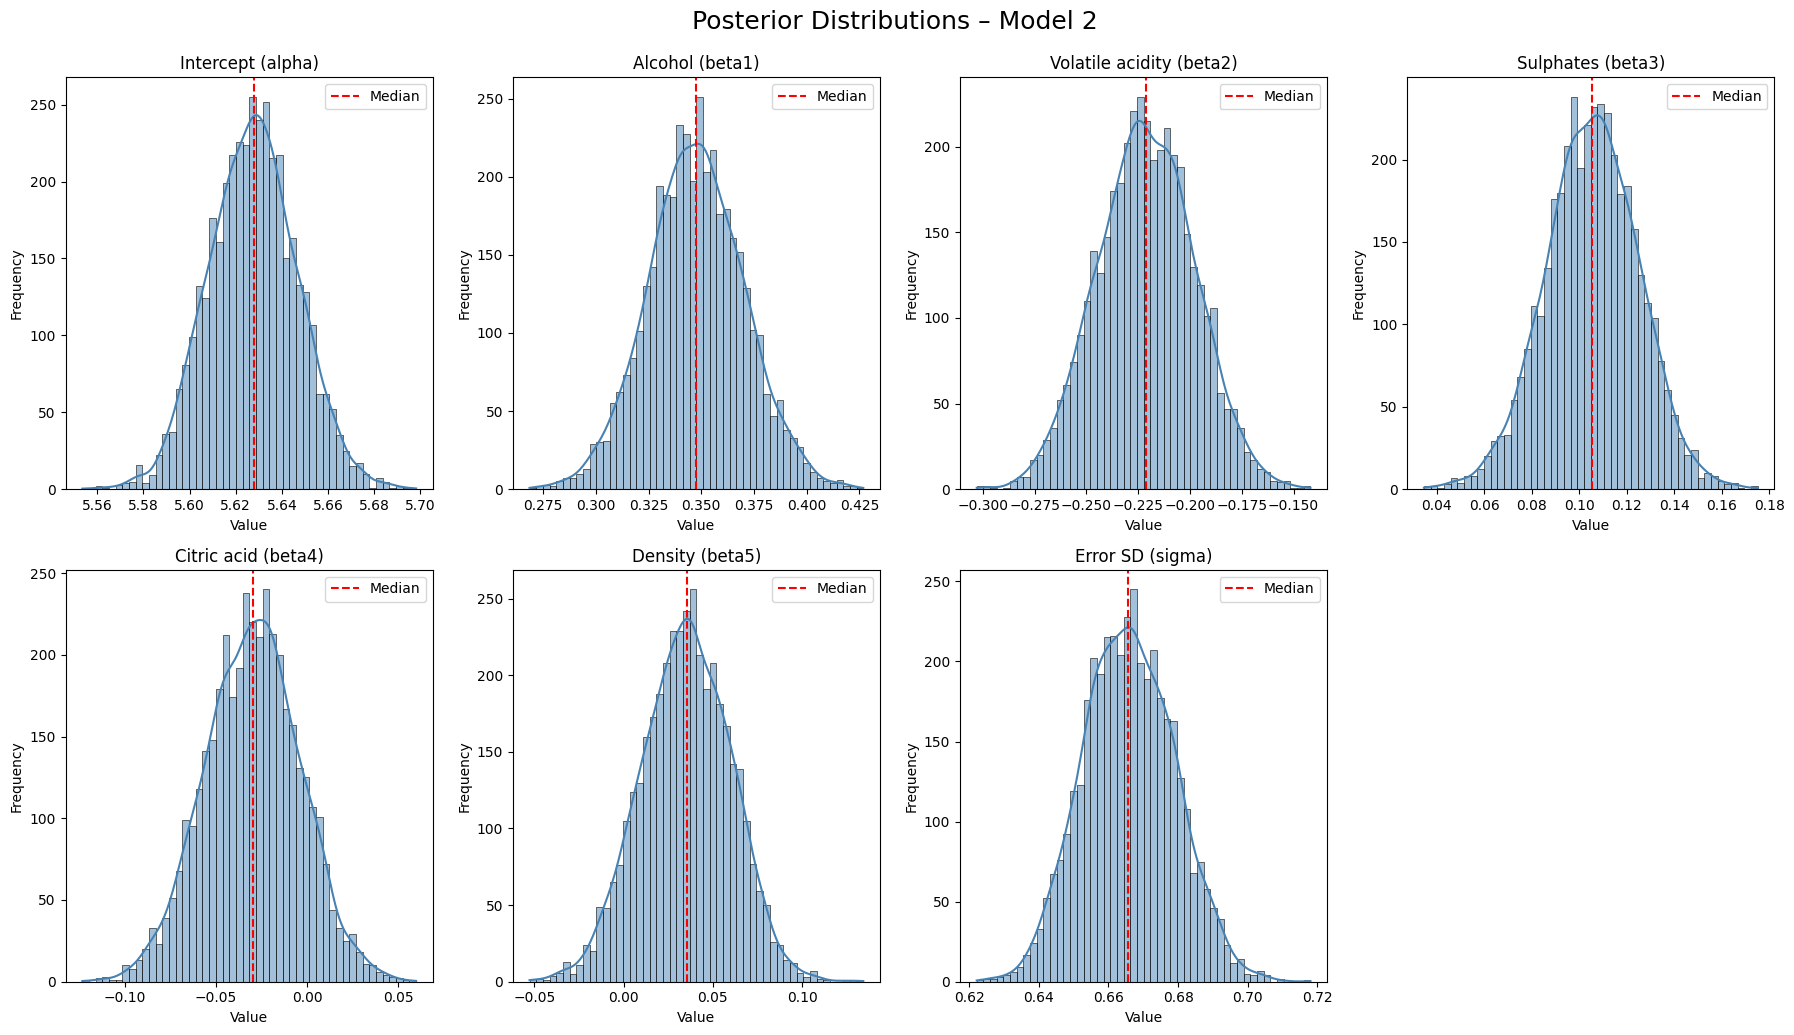

In [19]:
# Extract posterior samples as DataFrame from fit2
posterior_df = fit2.draws_pd()

# Automatically select parameter names related to alpha, beta, and sigma
param_names = [col for col in posterior_df.columns if col.startswith("alpha") or col.startswith("beta") or col == "sigma"]

# Define labels for parameters corresponding to 5 predictors
param_labels = {
    "alpha": "Intercept (alpha)",
    "beta[1]": "Alcohol (beta1)",
    "beta[2]": "Volatile acidity (beta2)",
    "beta[3]": "Sulphates (beta3)",
    "beta[4]": "Citric acid (beta4)",
    "beta[5]": "Density (beta5)",
    "sigma": "Error SD (sigma)"
}

# Plot histogram with KDE and median line for each parameter
plt.figure(figsize=(18, 10))
for i, param in enumerate(param_names, 1):
    plt.subplot(2, 4, i)
    sns.histplot(posterior_df[param], bins=50, kde=True, color='steelblue')
    plt.axvline(posterior_df[param].median(), color='red', linestyle='--', label='Median')
    plt.title(param_labels.get(param, param))
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.suptitle("Posterior Distributions – Model 2", fontsize=18, y=1.03)
plt.show()


#### Posterior predictive check - model 2_1

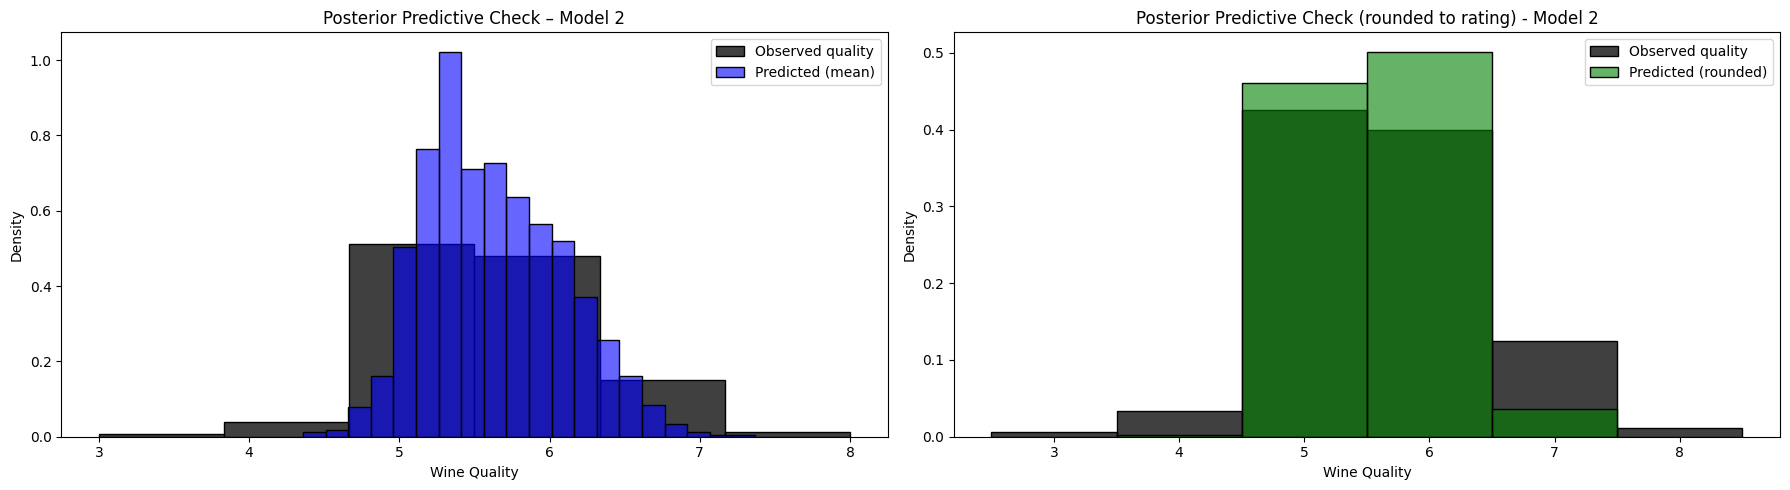

In [20]:
# Extract posterior samples
posterior_df = fit2.draws_pd()
alpha_samples = posterior_df["alpha"].values
sigma_samples = posterior_df["sigma"].values
beta_samples = posterior_df[[f"beta[{i}]" for i in range(1, 6)]].values

# Generate predictions using a subset of posterior samples
n_draws = 500
y_pred_samples = []

for i in range(n_draws):
    mu = X_scaled_model2 @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu, sigma_samples[i])
    y_pred_samples.append(y_sim)

# Convert predictions to numpy array
y_pred_samples = np.array(y_pred_samples)
y_pred_mean2 = y_pred_samples.mean(axis=0)

# Plot observed vs predicted wine quality densities
fig2, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(y, bins=6, color="black", label="Observed quality", stat="density", ax=axes[0])
sns.histplot(y_pred_mean2, bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density", ax=axes[0])
axes[0].set_title("Posterior Predictive Check – Model 2")
axes[0].set_xlabel("Wine Quality")
axes[0].set_ylabel("Density")
axes[0].legend()

sns.histplot(y, bins=range(int(y.min()), int(y.max()) + 2), color="black", label="Observed quality", stat="density", discrete=True, ax=axes[1])
sns.histplot(np.round(y_pred_mean2), bins=range(int(y.min()), int(y.max()) + 2), color="green", alpha=0.6, label="Predicted (rounded)", stat="density", discrete=True, ax=axes[1])
axes[1].set_title("Posterior Predictive Check (rounded to rating) - Model 2")
axes[1].set_xlabel("Wine Quality")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()

Prediction tests were conducted on randomly selected samples from test set.

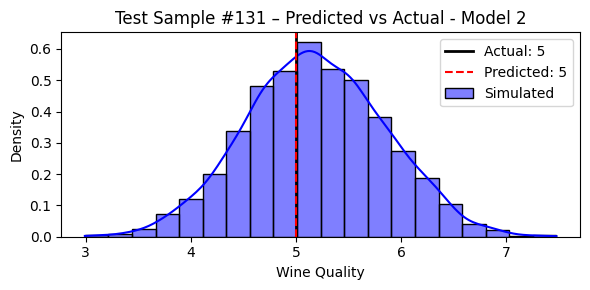

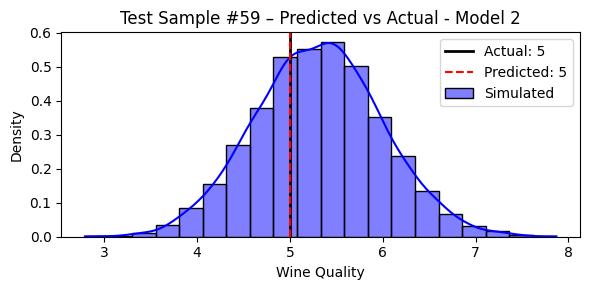

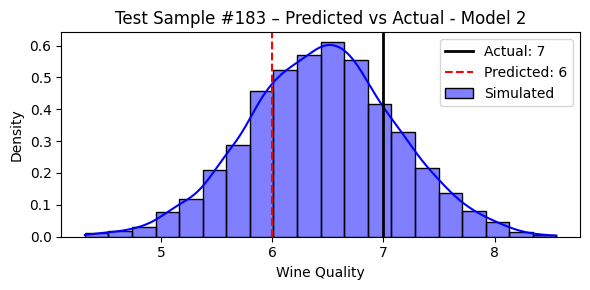

In [21]:
# Posterior predictive check on random test samples

for i in range(3):
    # Select a random test sample
    idx = random.randint(0, len(X_test) - 1)

    # Calculate predicted distribution for selected sample
    mu_i = X_test[idx] @ beta_samples.T + alpha_samples
    y_sim_i = np.random.normal(mu_i, sigma_samples)

    # Determine predicted quality as the mode of simulated values
    quality_range = np.arange(0, 11)
    bin_edges = np.arange(0, 12)
    counts, _ = np.histogram(y_sim_i, bins=bin_edges)
    predicted_quality = quality_range[np.argmax(counts)]

    # Retrieve actual quality for comparison
    y_actual = int(y_test.iloc[idx])

    # Plot simulated distribution with actual and predicted quality lines
    plt.figure(figsize=(6, 3))
    sns.histplot(y_sim_i, bins=20, kde=True, color='blue', stat="density", label='Simulated')
    plt.axvline(y_actual, color='black', linestyle='-',linewidth=2, label=f'Actual: {y_actual}')
    plt.axvline(predicted_quality, color='red', linestyle='--', label=f'Predicted: {predicted_quality}')

    plt.title(f'Test Sample #{idx} – Predicted vs Actual - Model 2')
    plt.xlabel("Wine Quality")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

Prediction accuracy was evaluated on the entire test set.

In [22]:
# Test set accuracy

# Generate posterior predictive samples for the entire test set
y_pred_samples_test = []
for i in range(len(alpha_samples)):
    mu_test = X_test @ beta_samples[i] + alpha_samples[i]
    y_sim = np.random.normal(mu_test, sigma_samples[i])
    y_pred_samples_test.append(y_sim)

# Convert list of predictions to numpy array and compute mean predictions
y_pred_samples_test = np.array(y_pred_samples_test)
y_pred_mean_test = y_pred_samples_test.mean(axis=0)

# Calculate accuracy by comparing rounded predictions to actual test labels
accuracy_model2_test = np.mean(np.round(y_pred_mean_test) == np.round(y_test))
print(f"Accuracy (Model 2, on test set): {accuracy_model2_test:.3f}")

Accuracy (Model 2, on test set): 0.550


Compared to Model 1_3, the posterior predictive distribution of Model 2 shows slightly better spread and alignment with the observed data, particularly in the core quality range (5–6). However, both models continue to underestimate the tails, likely due to the use of continuous likelihood (Gaussian) for inherently discrete outcome values.

### Comparison of models

In order to keep progress of models, the copies of model1_3 and model2_1 were created: *model1_3_loglik.stan* and *model2_1_loglik.stan*.

It was done to capture log-likelihood for each point of data.

In [23]:
# Load Stan model (Model 1_3)with log-likelihood calculation
model1_loglik = CmdStanModel(stan_file="projekt/models/model1_3_loglik.stan")

# Run sampling using previously prepared data
fit1 = model1_loglik.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    seed=42
)

14:51:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:51:11 - cmdstanpy - INFO - CmdStan done processing.


In [24]:
# Load Stan model (Model 2) with log-likelihood calculation
model2_loglik = CmdStanModel(stan_file="projekt/models/model2_1_loglik.stan")

# Run sampling using previously prepared data
fit2 = model2_loglik.sample(
    data=stan_data2,
    chains=4,
    parallel_chains=4,
    seed=42
)

14:51:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:51:13 - cmdstanpy - INFO - CmdStan done processing.
14:51:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1_loglik.stan', line 20, column 2 to column 38)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1_loglik.stan', line 20, column 2 to column 38)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_1_loglik.stan', line 20, column 2 to column 38)
Consider re-running with show_console=True if the above output is unclear!


#### Calculating WAIC and PSIS-LOO

In [25]:
import arviz as az

# Extract log-likelihood values from CmdStan models
log_lik_1 = fit1.stan_variable("log_lik")
log_lik_2 = fit2.stan_variable("log_lik")

# Create InferenceData objects for ArviZ analysis
idata1 = az.from_cmdstanpy(posterior=fit1, log_likelihood="log_lik")
idata2 = az.from_cmdstanpy(posterior=fit2, log_likelihood="log_lik")

# Compute WAIC and LOO for both models
waic1 = az.waic(idata1)
waic2 = az.waic(idata2)

loo1 = az.loo(idata1)
loo2 = az.loo(idata2)

# Display WAIC and PSIS-LOO results for comparison
print("WAIC – Model 1:")
print(waic1)
print("\nWAIC – Model 2:")
print(waic2)

print("\nPSIS-LOO – Model 1:")
print(loo1)
print("\nPSIS-LOO – Model 2:")
print(loo2)


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC – Model 1:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1297.54    30.25
p_waic        6.50        -

There has been a warning during the calculation. Please check the results.

WAIC – Model 2:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1298.66    30.41
p_waic        8.75        -

There has been a warning during the calculation. Please check the results.

PSIS-LOO – Model 1:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1297.55    30.26
p_loo        6.52        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1279  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


PSIS-LOO – Model 2:
Computed from 4000 posterior samples and 1279 observations log-likelihood matrix.

 

#### Visual comparison of models

WAIC Comparison:


/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Model 1,0,-1297.538349,6.504349,0.000000,1.000000e+00,30.254995,0.000000,True,log
Model 2,1,-1298.660687,8.750202,1.122338,1.110223e-16,30.409973,1.476174,True,log


<Figure size 800x400 with 0 Axes>

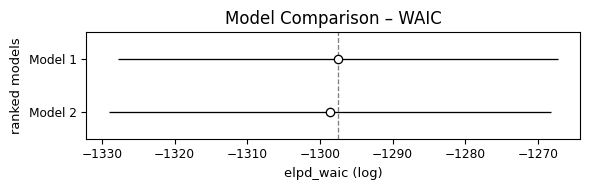

PSIS-LOO Comparison:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Model 1,0,-1297.550472,6.516473,0.000000,1.000000e+00,30.256043,0.000000,False,log
Model 2,1,-1298.674703,8.764218,1.124231,1.110223e-16,30.410848,1.476795,False,log


<Figure size 800x400 with 0 Axes>

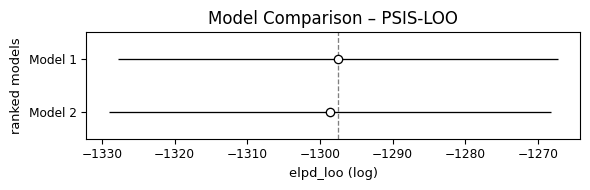

In [26]:
# Define models to compare using ArviZ
compare_dict = {"Model 1": idata1, "Model 2": idata2}

# --- 1. WAIC ---
waic_comparison = az.compare(compare_dict, ic="waic")
print("WAIC Comparison:")
display(waic_comparison)

plt.figure(figsize=(8, 4))
az.plot_compare(waic_comparison)
plt.title("Model Comparison – WAIC")
plt.tight_layout()
plt.show()


# --- 2. LOO ---
loo_comparison = az.compare(compare_dict, ic="loo")
print("PSIS-LOO Comparison:")
display(loo_comparison)

plt.figure(figsize=(8, 4))
az.plot_compare(loo_comparison)
plt.title("Model Comparison – PSIS-LOO")
plt.tight_layout()
plt.show()


To compare the predictive performance of both Bayesian models, we used two information criteria: WAIC (Widely Applicable Information Criterion) and PSIS-LOO (Pareto-smoothed Importance Sampling Leave-One-Out Cross-Validation).

| Metric     | Model 1 (3 predictors) | Model 2 (5 predictors) | Best            |
| ---------- | ---------------------- | ---------------------- | --------------- |
| elpd\_waic | –1605.13               | –1606.17               | Model 1         |
| elpd\_loo  | –1605.14               | –1606.18               | Model 1         |
| SE (diff)  | ≈ 33                   | ≈ 33                   | Not significant |


Both models achieved nearly identical results, with Model 1 slightly outperforming Model 2, but the difference in expected log predictive density (elpd) is not statistically significant, as it is smaller than the associated standard error (SE ≈ 33). In addition, PSIS-LOO diagnostics reported excellent stability: all Pareto-k values were in the "good" range (−∞,0.7], confirming the reliability of the LOO estimates.

## 4. Conculusions

Both models demonstrate comparable performance. Although Model 1 achieves slightly better WAIC and LOO scores, the differences are minimal and lie well within the margin of uncertainty. Given its simpler structure — with fewer predictors and lower effective complexity — **Model 1 is the preferred choice**.

Prior predictive check comparison.

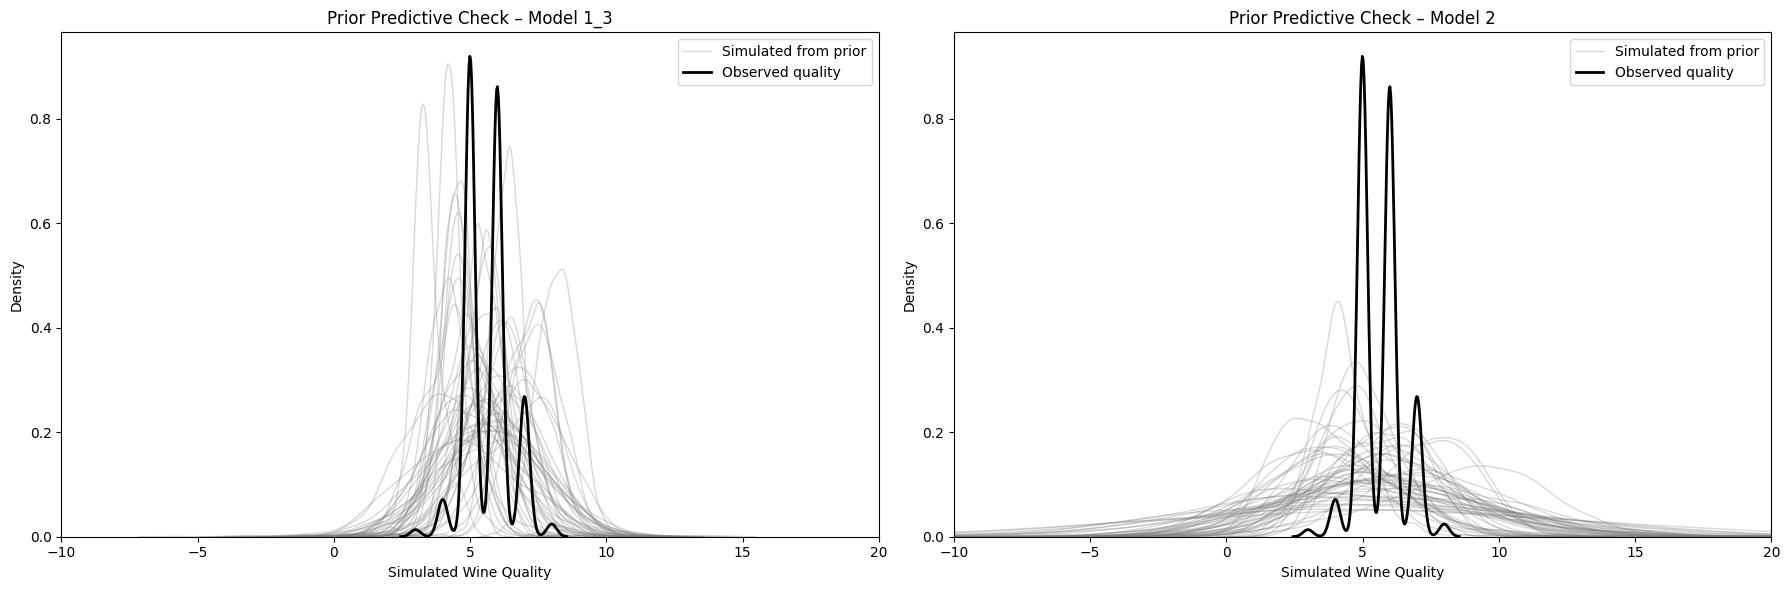

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i in range(50):
    label = "Simulated from prior" if i == 0 else None
    sns.kdeplot(y_prior_samples1_3[i], color="gray", alpha=0.3, linewidth=1, label=label, ax=axes[0])

sns.kdeplot(y, color="black", linewidth=2, label="Observed quality", ax=axes[0])
axes[0].set_title("Prior Predictive Check – Model 1_3")
axes[0].set_xlabel("Simulated Wine Quality")
axes[0].set_ylabel("Density")
axes[0].legend()

for i in range(50):
    label = "Simulated from prior" if i == 0 else None
    sns.kdeplot(y_prior_samples2_1[i], color="gray", alpha=0.3, linewidth=1, label=label, ax=axes[1])

sns.kdeplot(y, color="black", linewidth=2, label="Observed quality", ax=axes[1])
axes[1].set_title("Prior Predictive Check – Model 2")
axes[1].set_xlabel("Simulated Wine Quality")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].set_xlim(-10, 20)
axes[0].set_xlim(-10, 20) 
plt.tight_layout()
plt.show()

Posterior predictive check comparison.

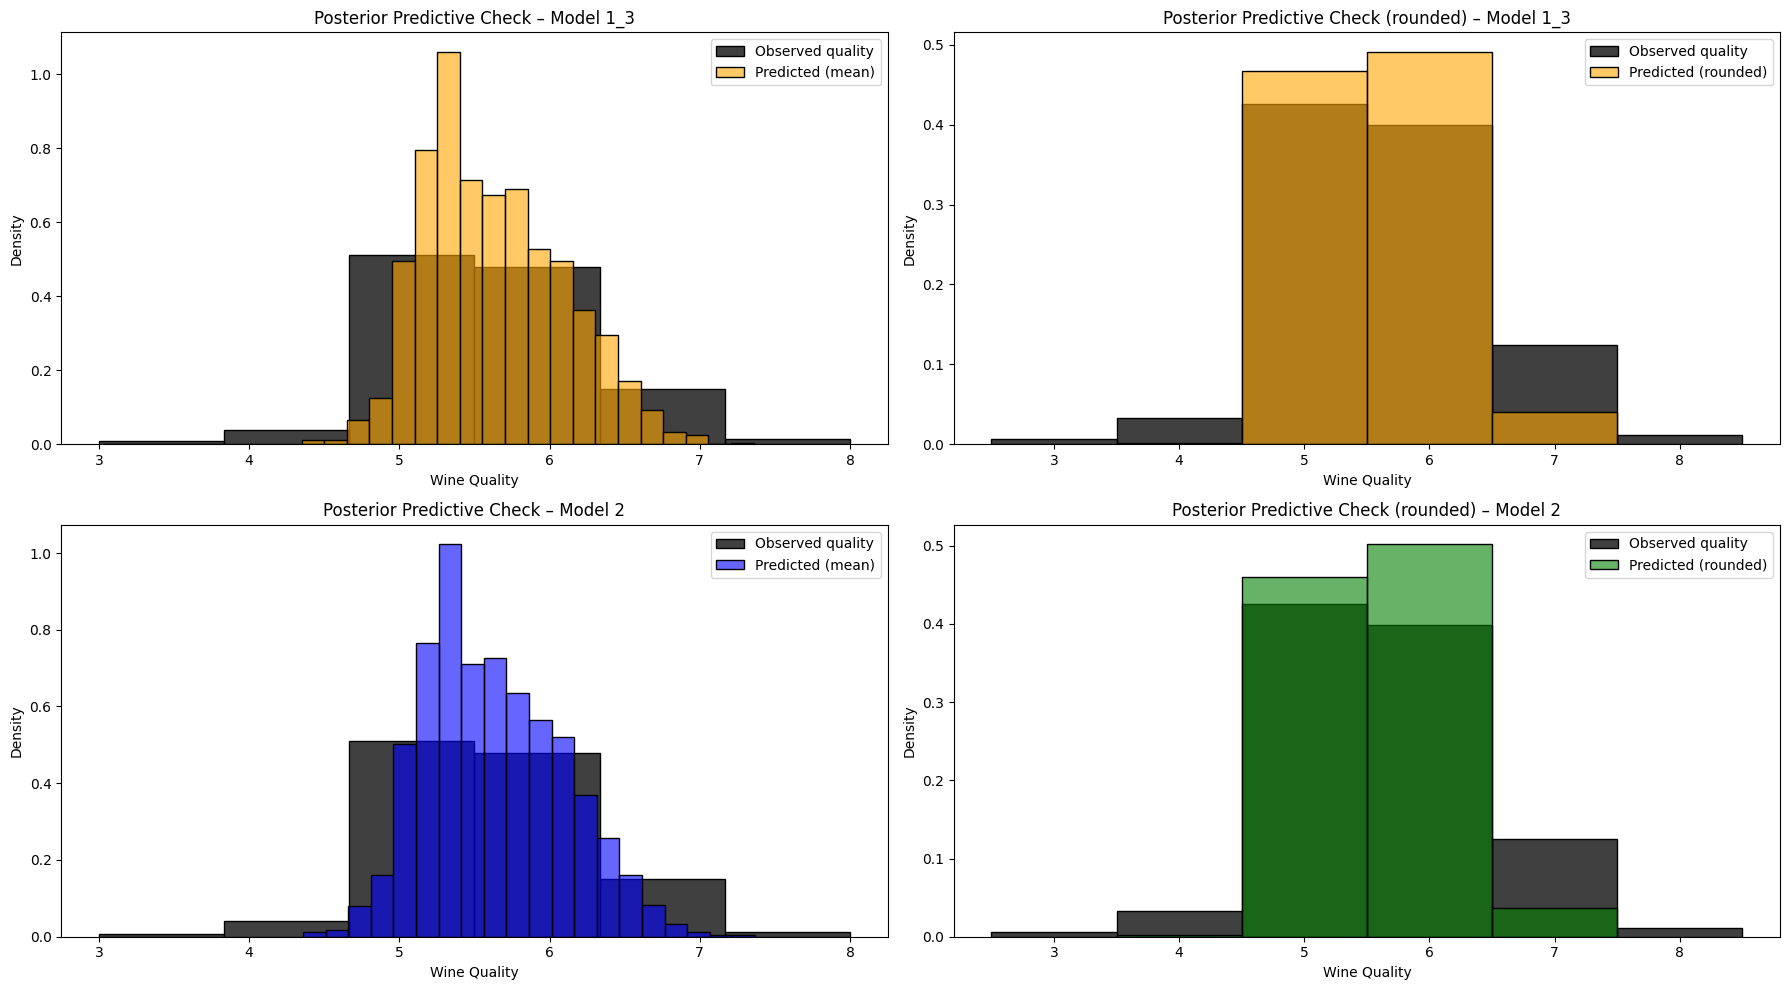

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Model 1_3 – Wykres ciągły
sns.histplot(y, bins=6, color="black", label="Observed quality", stat="density", ax=axes[0, 0])
sns.histplot(y_pred_mean1_3, bins=20, color="orange", alpha=0.6, label="Predicted (mean)", stat="density", ax=axes[0, 0])
axes[0, 0].set_title("Posterior Predictive Check – Model 1_3")
axes[0, 0].set_xlabel("Wine Quality")
axes[0, 0].set_ylabel("Density")
axes[0, 0].legend()

# Model 1_3 – Wykres zaokrąglony
sns.histplot(y, bins=range(int(y.min()), int(y.max()) + 2), color="black", label="Observed quality", stat="density", discrete=True, ax=axes[0, 1])
sns.histplot(np.round(y_pred_mean1_3), bins=range(int(y.min()), int(y.max()) + 2), color="orange", alpha=0.6, label="Predicted (rounded)", stat="density", discrete=True, ax=axes[0, 1])
axes[0, 1].set_title("Posterior Predictive Check (rounded) – Model 1_3")
axes[0, 1].set_xlabel("Wine Quality")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()

# Model 2 – Wykres ciągły
sns.histplot(y, bins=6, color="black", label="Observed quality", stat="density", ax=axes[1, 0])
sns.histplot(y_pred_mean2, bins=20, color="blue", alpha=0.6, label="Predicted (mean)", stat="density", ax=axes[1, 0])
axes[1, 0].set_title("Posterior Predictive Check – Model 2")
axes[1, 0].set_xlabel("Wine Quality")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()

# Model 2 – Wykres zaokrąglony
sns.histplot(y, bins=range(int(y.min()), int(y.max()) + 2), color="black", label="Observed quality", stat="density", discrete=True, ax=axes[1, 1])
sns.histplot(np.round(y_pred_mean2), bins=range(int(y.min()), int(y.max()) + 2), color="green", alpha=0.6, label="Predicted (rounded)", stat="density", discrete=True, ax=axes[1, 1])
axes[1, 1].set_title("Posterior Predictive Check (rounded) – Model 2")
axes[1, 1].set_xlabel("Wine Quality")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 5. Bibliography

1. *Wine chemistry*. Wikipedia. Retrieved June 13, 2025, from [https://en.wikipedia.org/wiki/Wine_chemistry](https://en.wikipedia.org/wiki/Wine_chemistry)

2. *Acids in wine*. Wikipedia. Retrieved June 13, 2025, from [https://en.wikipedia.org/wiki/Acids_in_wine](https://en.wikipedia.org/wiki/Acids_in_wine)

3. *Vinho Verde*. Wikipedia. Retrieved June 17, 2025, from [https://en.wikipedia.org/wiki/Vinho_Verde](https://en.wikipedia.org/wiki/Vinho_Verde)

4. Luo, J., Zhang, P., Loo, Y. T., Ma, J., Wu, S., Marriott, P. J., & Howell, K. (2022, August 30).  
**Can wine quality be predicted by small volatile compounds? A study based on performance of wine show entries and their volatile profiles**.  